In [1]:
import numpy as np
from multiprocessing import managers, shared_memory
import enum
from concurrent import futures
import xarray as xr
import gcsfs
from typing import Dict, List, Union, Callable
import torch
from collections import namedtuple
from dataclasses import dataclass
from functools import partial
import cv2 as cv
import matplotlib.pyplot as plt

In [2]:
import pytorch_lightning as pl
from torch import nn
import torch.nn.functional as F

In [3]:
HRV_CHANNEL = 0

In [4]:
plt.rcParams['figure.figsize'] = (10, 10)

In [5]:
ZARR = 'solar-pv-nowcasting-data/satellite/EUMETSAT/SEVIRI_RSS/OSGB36/all_zarr_int16'


def get_sat_dataset(filename=ZARR):
    gcs = gcsfs.GCSFileSystem()
    store = gcsfs.GCSMap(root=filename, gcs=gcs)
    dataset = xr.open_zarr(store, consolidated=True)
    return dataset

In [6]:
%%time
dataset = get_sat_dataset()

CPU times: user 1.96 s, sys: 116 ms, total: 2.08 s
Wall time: 4.05 s


In [7]:
# TODO: Rename this variable - it's a bit ambiguous what it refers to
OPT_FLOW_DTYPE = np.float32


def convert_10bpp_to_uint8(array):
    "Convert 10 bit per pixel to uint8"
    # Divide by 4 to get from a range of [0, 1023] to [0, 255].
    array = array / 4.0
    array = array.round()
    assert array.min() >= 0
    assert array.max() <= 255
    return array.astype(np.uint8)


def _compute_optical_flow(sat_data: np.ndarray, timestep: int) -> np.ndarray:
    """
    Args:
        sat_data: uint8 numpy array of shape (num_timesteps, height, width)
        timestep: The timestep to process.
        
    Returns:
        optical flow field
    """
    prev_img = sat_data[timestep]
    next_img = sat_data[timestep+1]
    return cv.calcOpticalFlowFarneback(
        prev=prev_img, next=next_img, flow=None, pyr_scale=0.5, levels=2, winsize=40, iterations=3, 
        poly_n=5, poly_sigma=0.7, flags=cv.OPTFLOW_FARNEBACK_GAUSSIAN)


def _get_opt_flow_shape(sat_data_shape):
    num_timesteps, height, width = sat_data_shape
    num_flows = num_timesteps - 2
    opt_flow_shape = (num_flows, height, width, 2)
    return opt_flow_shape


def _compute_optical_flow_worker_process(
    timestep: int, 
    sat_data_shape: tuple, 
    sat_data_shared_mem: shared_memory.SharedMemory, 
    opt_flow_shared_mem: shared_memory.SharedMemory) -> None:
    """To be run as a separate process. Gets sat data from shared memory.
    Computes optical flow for pair of images (at timesteps t and t+1).
    
    Args:
        timestep: Index into sat_data for the first image on which to compute
            optical flow.  The 2nd image used for optical flow is at timestep+1.
        sat_data_shape: Tuple of (num_timesteps, height, width)
        sat_data_shared_mem: SharedMemory object.  Note that the full array isn't copied into
            each process.  Instead, memory is shared between processes.  uint8
        opt_flow_shared_mem: SharedMemory into which this function inserts the computed optical flow field.
    """
    # Attach to existing memory block for satellite data.
    sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
    
    # Attach to existing memory block for the optical flow fields.
    opt_flow_shape = _get_opt_flow_shape(sat_data_shape)
    opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

    # Compute optical flow.
    flow = _compute_optical_flow(sat_data_shared_array, timestep)
    
    # Copy flow to shared memory.
    opt_flow_shared_array[timestep] = flow[:]


def compute_optical_flow(sat_data: xr.DataArray) -> xr.DataArray:
    """Compute optical flow for each pair of consecutive images using multiple processes.

    Args:
        sat_data: Satellite data loaded from disk, 10 bits per channel.
        
    Returns:
        optical flow fields as xr.DataArray, with the 'time' dimension set to
        the time of the second of the pair of input satellite images,
        using dtype OPT_FLOW_DTYPE.
    """
    # OpenCV expects uint8 images
    sat_data_uint8 = convert_10bpp_to_uint8(sat_data)
    
    # Shape maths :)
    sat_data_shape = sat_data_uint8.shape
    opt_flow_shape = _get_opt_flow_shape(sat_data_shape)
    num_timesteps = sat_data_shape[0]
    num_flows = num_timesteps - 2
    
    # Create a non-shared array for the resulting optical flow fields.
    opt_flow_array = np.empty(opt_flow_shape, dtype=OPT_FLOW_DTYPE)

    # To speed up processing, we use multiple processes to compute the optical flow fields.
    # Prior to Python 3.8, we'd have to pass the sat data array and the optical flow
    # arrays using pipes or on-disk files.  That's slow.  Python 3.8 allows us to share
    # memory between processes, which is much faster.
    with managers.SharedMemoryManager() as smm:
        # Create shared array for the uint8 satellite imagery.
        sat_data_shared_mem = smm.SharedMemory(size=sat_data_uint8.nbytes)
        sat_data_shared_array = np.ndarray(sat_data_shape, dtype=np.uint8, buffer=sat_data_shared_mem.buf)
        sat_data_shared_array[:] = sat_data_uint8[:]

        # Create a shared array for the resulting optical flow fields.
        opt_flow_shared_mem = smm.SharedMemory(size=opt_flow_array.nbytes)
        opt_flow_shared_array = np.ndarray(opt_flow_shape, dtype=OPT_FLOW_DTYPE, buffer=opt_flow_shared_mem.buf)

        # Fire up a bunch of processes to compute optical flow indexed on the first
        # image of the pair of images to compute optical flow for.  ProcessPoolExecutor
        # defaults to use the number of processors on the machine.
        
        opt_flow_func = partial(
            _compute_optical_flow_worker_process, 
            sat_data_shape=sat_data_shape,
            sat_data_shared_mem=sat_data_shared_mem,
            opt_flow_shared_mem=opt_flow_shared_mem)
        with futures.ProcessPoolExecutor() as executor:
            iterator = executor.map(opt_flow_func, range(num_flows))
            
        # Need to iterate through the returned iterator to raise
        # and exceptions raised by worker processes during executor.map().
        list(iterator)

        # Copy results into non-shared array before we leave the
        # SharedMemoryManager context manager.
        opt_flow_array[:] = opt_flow_shared_array[:]

    # Wrap opt_flow_array in an xr.DataArray with appropriate dimensions.
    coords = (
        ('time', sat_data['time'][1:-1]),
        ('y', sat_data['y']),
        ('x', sat_data['x']),
        ('optical_flow_displacement', ['x', 'y']))
    
    return xr.DataArray(opt_flow_array, coords=coords, name='optical flow')

In [8]:
# Quick test of compute_optical_flow
#sat_data = dataset.isel(time=slice(100, 110))['stacked_eumetsat_data'][..., HRV_CHANNEL]
#sat_data[0].plot();

In [9]:
def remap_image(image: np.ndarray, flow: np.ndarray) -> np.ndarray:
    """Takes an image and warps it forwards in time according to the flow field.
    
    Args:
        image: The grayscale image to warp.
        flow: A 3D array.  The first two dimensions must be the same size as the first two
            dimensions of the image.  The third dimension represented the x and y displacement.
            
    Returns:  Warped image.  The border has values np.NaN.
    """
    # Adapted from https://github.com/opencv/opencv/issues/11068
    height, width = flow.shape[:2]
    remap = -flow.copy()
    remap[..., 0] += np.arange(width)  # map_x
    remap[..., 1] += np.arange(height)[:, np.newaxis]  # map_y
    # cv.remap docs: https://docs.opencv.org/4.5.0/da/d54/group__imgproc__transform.html#gab75ef31ce5cdfb5c44b6da5f3b908ea4
    return cv.remap(
        src=image, map1=remap, map2=None, 
        interpolation=cv.INTER_LINEAR, 
        # See BorderTypes: https://docs.opencv.org/4.5.0/d2/de8/group__core__array.html#ga209f2f4869e304c82d07739337eae7c5
        borderMode=cv.BORDER_CONSTANT,
        borderValue=np.NaN
    )


def compute_optical_flow_predictions(sat_data: xr.DataArray, flows: xr.DataArray):
    """Compute predictions.

    For each source image (S), and optical flow field (F), we create a predicted image (P) like this:

    source image timestep: 012345
                           SSSSSS
                            FFFF
                             PPPP
                              PPP
                               PP
                                P

    For n source images, we have n-2 flows, and (n-2)*(n-1)/2 predictions.  In the illustration,
    we have 6 source images, 4 flows, and 10 predictions.

    Source image 0 and 1 make the first flow.  Source image 0 and the first flow go into
    making the first prediction (which is for source timestep 2.  That is, we take source image
    1 and predict source image 2.)
    
    Returns metadata, predictions
        metadata: a list of dicts. Each dict has keys 'date_forecast_about' (np.datetime64)
          and 'forecast_horizon' (np.timedelta64).  There is one metadata entry for each prediction.
        predictions: np.ndarray of shape (num_predictions, height, width)
    """

    num_source_timesteps, height, width = sat_data.shape
    num_predictions = int((num_source_timesteps-2) * (num_source_timesteps-1) / 2)
    predictions_shape = (num_predictions, height, width)
    predictions = np.empty(predictions_shape, dtype=np.float32)

    num_flows = num_source_timesteps - 2
    prediction_i = 0
    prediction_metadata = []

    for flow_i in range(num_flows):
        #print(f'FLOW {flow_i:02d}: ', end='')
        for forecast_horizon in range(1, (num_flows - flow_i)+1):
            #print(f'{prediction_i:03d},{forecast_horizon} ', end='')
            first_image = sat_data[flow_i+1]
            flow = flows[flow_i].values * forecast_horizon
            predicted_image = remap_image(first_image.values, flow)
            predictions[prediction_i] = predicted_image[:]

            forecast_horizon_td = np.timedelta64(forecast_horizon * MINUTES_PER_TIMESTEP, 'm')
            prediction_metadata.append({
                'date_forecast_about': first_image['time'].values + forecast_horizon_td,
                'forecast_horizon': forecast_horizon_td})
            prediction_i += 1
        #print()
        
    return {'metadata': prediction_metadata, 'images': predictions}

In [10]:
INPUT_IMAGES = 'input_images'
INPUT_METADATA = 'input_metadata'
TARGET_IMAGES = 'target_images'
INPUT_IDX_TO_TARGET_IDX = 'input_idx_to_target_idx'
OPTICAL_FLOW = 'optical_flow'

In [59]:
def normalise_images(super_batch: Dict):
    for attr_name in (INPUT_IMAGES, TARGET_IMAGES):
        attr = super_batch[attr_name]
        attr -= 93.23458
        attr /= 115.34247

In [60]:
TIMESTEPS_PER_HOUR = 12  # One timestep every 5 minutes.
MINUTES_PER_TIMESTEP = 5
NUM_RETRIES = 5

DateRange = namedtuple('DateRange', ['start', 'end'])


class BatchType(enum.Enum):
    TRAINING = 0
    TESTING = 1
    

@dataclass
class SatelliteLoader:
    """Loads satellite data from disk into CPU memory.
    
    Optical flow & optical flow predictions are computed in parallel on the fly.
    
    We don't explicity set a date range for training so the code can 
    automatically make use of new training data when the dataset is updated
    with new satellite data.

    Init params:
        dataset: xarray dataset of int16 EUMETSAT satellite images.
        num_epochs:
        num_forecast_timesteps: Number of timesteps ahead to predict.  Each timestep is 5 minutes long.
        testing_date_range: Date range to exclude from training data.  
            If the testing_date_range contains more data
            than can fit into a single super batch then the chronologically late
            data will not be used in either training or testing.
        rng: Random number generator.
    """
    dataset: xr.Dataset  # The only variable that _has_ to be passed in.
    num_epochs: int = 20
    num_forecast_timesteps: int = 24

    # TODO: Accept multiple date ranges.
    testing_date_range: DateRange = DateRange(start=np.datetime64('2019-06-01'), end=np.datetime64('2019-06-14'))

    rng: np.random.Generator = np.random.default_rng()

    def __post_init__(self):
        # Select just the HRV channel.
        HRV_CHANNEL = 0
        data_array = self.dataset['stacked_eumetsat_data'][..., HRV_CHANNEL]

        # Our int16 array represents NaNs as '-1'.  Lazily replace -1s with NaNs.
        data_array = data_array.astype(np.float32).where(data_array != -1, np.NaN)
        self.data_array = data_array

        # valid_start_dates is a dict mapping TRAINING and TESTING to valid start dates.
        self.valid_start_times = self._compute_valid_start_times(data_array['time'])
        
    def _compute_valid_start_times(self, datetimes) -> Dict[BatchType, np.array]:
        """Find start times for testing and training.
        
        Returns dict {TESTING: array of dates; TRAINING: array of dates}"""

        # TODO: Use clear sky irradiance to compute good hours.
        # TODO: Only select start-times which align with the start of Zarr chunks?

        datetime_index = datetimes.to_index()
        hours = datetime_index.hour
        forecast_hours = self.num_forecast_timesteps / TIMESTEPS_PER_HOUR
        end_hour = 16 - forecast_hours
        mask = (hours > 9) & (hours < end_hour)
        masked_datetimes = datetimes[mask]

        testing_mask = (self.testing_date_range.start < masked_datetimes) &  (self.testing_date_range.end > masked_datetimes)
        return {
            BatchType.TRAINING: masked_datetimes[~testing_mask].values,
            BatchType.TESTING: masked_datetimes[testing_mask].values}

    def load_satellite_data(self, batch_type: BatchType=BatchType.TRAINING) -> xr.DataArray:
        """Randomly pick a chunk of data to load off disk.

        Args:
            batch_type: Select training or testing.
        """
        # TODO: Load several complete chunks at once to make best use of Zarr's parallel reading.
        # We'll need to modify compute_optical_flow so it doesn't attempt to compute
        # optical flow for two images which are not exactly consecutive.
        
        # TODO: Figure out how many Zarr chunks to load so that the
        # resulting data fits into a super batch.
        # Consider: For the last forecast_timesteps steps in a consecutive chunk,
        # we'll have decreasingly few ground-truth examples.

        start_times = self.valid_start_times[batch_type]
        
        for retry in range(NUM_RETRIES):
            start_time = self.rng.choice(start_times)
            end_time = start_time + np.timedelta64(self.num_forecast_timesteps * MINUTES_PER_TIMESTEP, 'm')
            sat_data = self.data_array.sel(time=slice(start_time, end_time))
            if len(sat_data) == self.num_forecast_timesteps + 1:
                # Found good data!
                break
        else:
            raise ValueError(f'Failed to find valid data after {NUM_RETRIES} retries!')
            
        return sat_data.compute()

    def load_super_batch(self, batch_type: BatchType=BatchType.TRAINING) -> Dict[str, Union[xr.DataArray, np.ndarray]]:
        """
        Returns dict with:
        input_images: Optical flow predictions - full geographical extent), length _n_.
        input_metadata: Forecast horizon of the optical flow images, length _n_.
        target_images: Ground-truth satellite images - full geographical extent)
        input_idc_to_target_idx: Map from input index to target index (because many input
            images map to each target image).  This will be a 1D interger array, length _n_,
            where each value gives the corresponding target image index.
        """
        satellite_data = self.load_satellite_data(batch_type)
        optical_flow = compute_optical_flow(satellite_data)
        # TODO:  Rolling average of flow fields.

        opt_flow_predictions = compute_optical_flow_predictions(satellite_data, optical_flow)
        
        input_datetimes = [d['date_forecast_about'] for d in opt_flow_predictions['metadata']]
        
        super_batch = {
            # OPTICAL_FLOW: optical_flow,
            INPUT_IMAGES: opt_flow_predictions['images'],
            INPUT_METADATA: opt_flow_predictions['metadata'],
            TARGET_IMAGES: satellite_data,
            INPUT_IDX_TO_TARGET_IDX: np.array(
                [np.where(satellite_data.time.values == input_datetime)[0][0]
                    for input_datetime in input_datetimes])}

        normalise_images(super_batch)
        
        return super_batch

In [61]:
def sat_data_loader_process(queue):
    dataset = get_sat_dataset()
    sat_loader = SatelliteLoader(dataset)
    while True:
        super_batch = sat_loader.load_super_batch()
        queue.put(super_batch)

In [13]:
import multiprocessing

In [ ]:
queue = multiprocessing.Queue(10)
process = multiprocessing.Process(target=sat_data_loader_process, args=(queue, ))
process.start()

Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good data after 0 retries.
Found good

In [15]:
process

<Process name='Process-1' pid=4101 parent=4088 started>

In [16]:
super_batch = queue.get()

--------------------

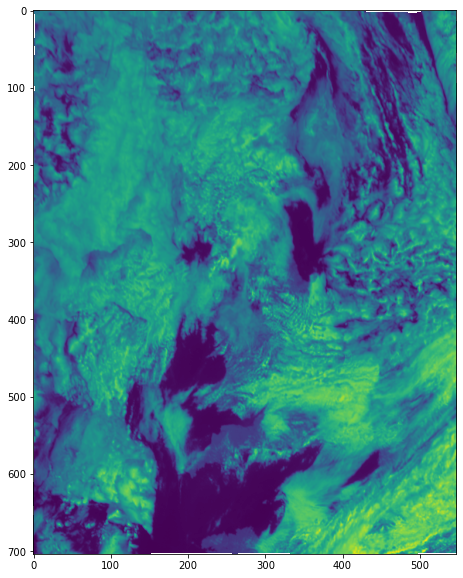

In [17]:
i = 0
plt.imshow(super_batch['input_images'][i]);

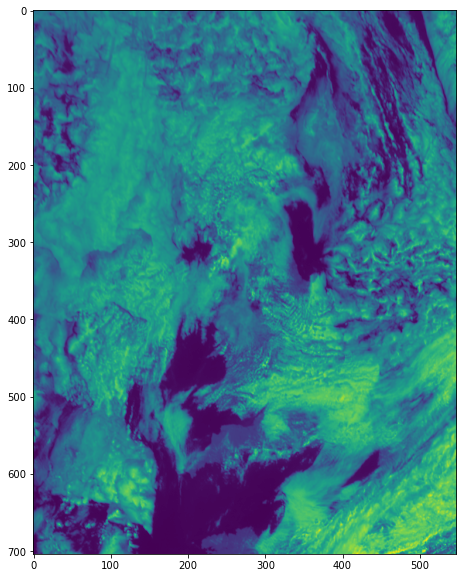

In [18]:
plt.imshow(super_batch['target_images'].sel(time=super_batch['input_metadata'][i]['date_forecast_about']));

In [19]:
super_batch['input_images'].nbytes / 1E6

425.914368

In [20]:
super_batch['target_images'].nbytes / 1E6

38.5792

In [21]:
from typing import Dict, Optional, Callable
import numpy as np
import torch
from dataclasses import dataclass

In [66]:
def sample_squares(
    mini_batch_full_geo_extent: Dict[str, np.ndarray],
    n_pixels_per_side: int = 128,
    rng: Optional[np.random.Generator] = None
    ) -> Dict[str, np.ndarray]:
    """For each example, samples a random square from input_images and target_images.
    
    Ignores squares where optical flow predictions include NaNs (i.e. ignores
    the 'smeared' edges of the optical flow predictions).
    """
    if rng is None:
        rng = np.random.default_rng()
    input_images = mini_batch_full_geo_extent[INPUT_IMAGES]
    target_images = mini_batch_full_geo_extent[TARGET_IMAGES]
    n_images, height, width = input_images.shape
    cropped_shape = (n_images, n_pixels_per_side, n_pixels_per_side)
    dtype = input_images.dtype
    
    # Pre-allocate memory.
    input_images_cropped = np.empty(cropped_shape, dtype=dtype)
    target_images_cropped = np.empty(cropped_shape, dtype=dtype)
    
    # Randomly pick the top-left corner of the square to crop.
    max_x = width - n_pixels_per_side
    max_y = height - n_pixels_per_side
    
    for img_i in range(n_images):
        # Keep retrying until we pick a square which has no NaNs:
        for _ in range(1000):
            top = rng.integers(low=0, high=max_y)
            bottom = top + n_pixels_per_side
            left = rng.integers(low=0, high=max_x)
            right = left + n_pixels_per_side
            
            input_images_cropped[img_i] = input_images[img_i, top:bottom, left:right]
            if not np.any(np.isnan(input_images_cropped[img_i])):
                target_images_cropped[img_i] = target_images[img_i, top:bottom, left:right]
                break
            
            # else, if we get here, we need to try again because the crop had NaNs!
    
    return {
        INPUT_IMAGES: input_images_cropped,
        TARGET_IMAGES: target_images_cropped}

In [70]:
def super_batch_to_example(
    super_batch: Dict[str, object], 
    input_idx: int, rng: 
    Optional[np.random.Generator] = None) -> Dict[str, object]:
    
    target_idx = super_batch[INPUT_IDX_TO_TARGET_IDX][input_idx]
    example = {
        INPUT_IMAGES: super_batch[INPUT_IMAGES][input_idx][np.newaxis, ...],
        TARGET_IMAGES: super_batch[TARGET_IMAGES].values[target_idx][np.newaxis, ...]}
    example = sample_squares(example, rng=rng)
    return example

In [79]:
class ValidationDataset(torch.utils.data.Dataset):
    def __init__(self):
        dataset = get_sat_dataset()
        sat_loader = SatelliteLoader(dataset)
        self.examples = []
        for super_batch_i in range(8):
            print('Loading super_batch', super_batch_i)
            super_batch = sat_loader.load_super_batch(batch_type=BatchType.TESTING)
            n_input_images = len(super_batch[INPUT_IMAGES])
            for input_idx in range(n_input_images):
                example = super_batch_to_example(super_batch, input_idx)
                self.examples.append(example)
                
    def __len__(self):
        return len(self.examples)
    
    def __getitem__(self, idx):
        return self.examples[idx]

In [80]:
%%time
val_dataset = ValidationDataset()

Loading super_batch 0
Loading super_batch 1
Loading super_batch 2
Loading super_batch 3
Loading super_batch 4
Loading super_batch 5
Loading super_batch 6
Loading super_batch 7
CPU times: user 58.1 s, sys: 12.7 s, total: 1min 10s
Wall time: 48.2 s


In [81]:
len(val_dataset)

2208

In [83]:
val_dataloader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    pin_memory=True,
    drop_last=True,
    num_workers=4
)

In [24]:
@dataclass
class InMemDataset(torch.utils.data.IterableDataset):
    sat_loader_queue: multiprocessing.Queue
    n_super_batches: int = 8
    n_examples_per_epoch: int = 2048
    
    def __post_init__(self):
        self.rng = np.random.default_rng()
        self.super_batches = []
        self._super_batch_to_replace = 0
        for i in range(self.n_super_batches):
            print('Loading super_batch', i)
            self.super_batches.append(self.sat_loader_queue.get())
    
    def __iter__(self):
        for _ in range(self.n_examples_per_epoch):
            super_batch_i = self.rng.integers(low=0, high=self.n_super_batches, dtype=np.uint8)
            super_batch = self.super_batches[super_batch_i]
            n_input_images = len(super_batch[INPUT_IMAGES])
            input_idx = self.rng.integers(low=0, high=n_input_images)
            example = super_batch_to_example(super_batch, input_idx, self.rng)
            yield example
            
        self._get_new_batch()
            
    def _get_new_batch(self):
        self.super_batches[self._super_batch_to_replace] = self.sat_loader_queue.get()
        self._super_batch_to_replace += 1
        if self._super_batch_to_replace >= self.n_super_batches:
            self._super_batch_to_replace = 0

In [25]:
in_mem_dataset = InMemDataset(sat_loader_queue=queue)

Loading super_batch 0
Loading super_batch 1
Loading super_batch 2
Loading super_batch 3
Loading super_batch 4
Loading super_batch 5
Loading super_batch 6
Loading super_batch 7


In [26]:
dataloader = torch.utils.data.DataLoader(
    in_mem_dataset,
    batch_size=16,
    pin_memory=True,
    drop_last=True,
    #num_workers=8
)

In [29]:
%%time
for d in dataloader:
    break

CPU times: user 13.7 ms, sys: 4.98 ms, total: 18.7 ms
Wall time: 16.4 ms


In [30]:
d[INPUT_IMAGES].shape

torch.Size([16, 1, 128, 128])

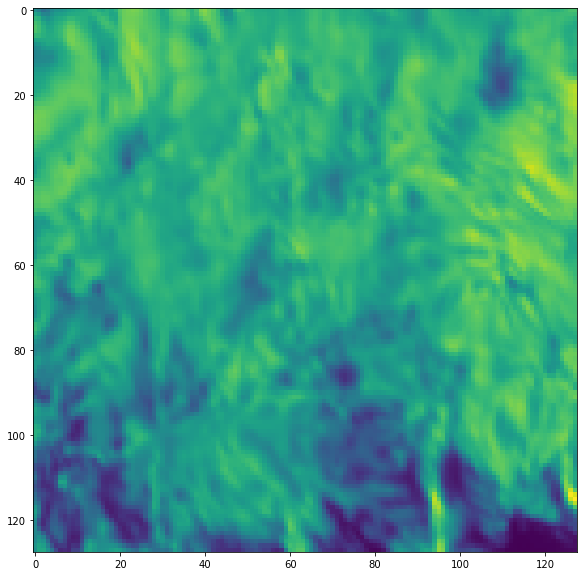

In [31]:
batch_i = 2
plt.imshow(d[INPUT_IMAGES][batch_i][0])

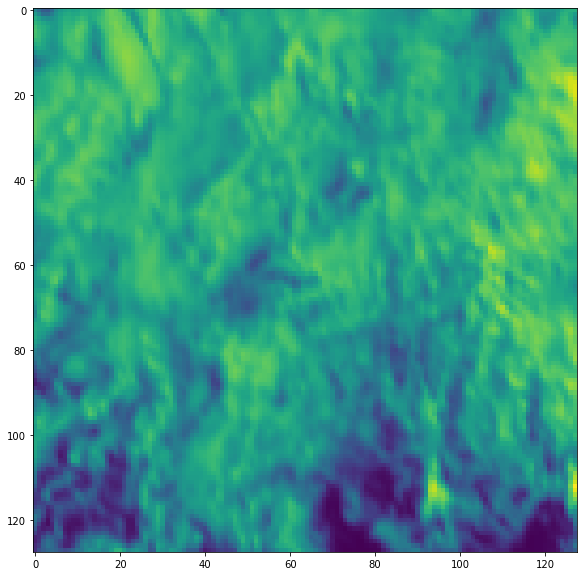

In [32]:
plt.imshow(d[TARGET_IMAGES][batch_i][0])

In [33]:
d[TARGET_IMAGES][batch_i+5][0].mean()

tensor(-0.3970)

In [96]:
class LitAutoEncoder(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.ConvTranspose2d(in_channels=32, out_channels=1, kernel_size=3),
        )

    def forward(self, x):
        # in lightning, forward defines the prediction/inference actions
        embedding = self.encoder(x)
        output = self.decoder(embedding)
        return output
    
    def _training_or_validation_step(self, batch, is_train_step):
        x = batch[INPUT_IMAGES]
        y = batch[TARGET_IMAGES]
        y_hat = self(x)
        loss = F.mse_loss(y_hat, y)
        tag = "Loss/Train" if is_train_step else "Loss/Validation"
        self.log_dict({tag: loss}, on_step=is_train_step, on_epoch=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=True)
    
    def validation_step(self, batch, batch_idx):
        return self._training_or_validation_step(batch, is_train_step=False)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.0001)
        return optimizer

In [97]:
model = LitAutoEncoder()

In [98]:
logger = pl.loggers.TensorBoardLogger(save_dir='tensorboard_logs')

In [99]:
trainer = pl.Trainer(gpus=1, max_epochs=30, logger=logger)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [100]:
# trainer.max_epochs = 60

In [ ]:
%%time
trainer.fit(model, train_dataloader=dataloader, val_dataloaders=val_dataloader)


  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 18.8 K
1 | decoder | Sequential | 18.8 K


Epoch 0: : 129it [00:08, 16.11it/s, loss=0.267, v_num=3]
Epoch 0: : 144it [00:08, 17.76it/s, loss=0.267, v_num=3]
Validating:  12%|█▏        | 16/138 [00:00<00:00, 151.98it/s]
Epoch 0: : 159it [00:08, 19.30it/s, loss=0.267, v_num=3]it/s]
Epoch 0: : 176it [00:08, 21.09it/s, loss=0.267, v_num=3]it/s]
Epoch 0: : 193it [00:08, 22.60it/s, loss=0.267, v_num=3]it/s]
Validating:  49%|████▊     | 67/138 [00:00<00:00, 103.56it/s]
Epoch 0: : 210it [00:08, 23.87it/s, loss=0.267, v_num=3]t/s] 
Validating:  62%|██████▏   | 86/138 [00:00<00:00, 78.78it/s]
Epoch 0: : 227it [00:09, 25.04it/s, loss=0.267, v_num=3]t/s]
Validating:  74%|███████▍  | 102/138 [00:01<00:00, 70.94it/s]
Epoch 0: : 244it [00:09, 26.16it/s, loss=0.267, v_num=3]it/s]
Validating:  90%|████████▉ | 124/138 [00:01<00:00, 65.41it/s]
Epoch 0: : 261it [00:09, 26.91it/s, loss=0.267, v_num=3]it/s]
Epoch 0: : 267it [00:10, 26.30it/s, loss=0.267, v_num=3]it/s]
Epoch 1: : 128it [00:08, 15.48it/s, loss=0.254, v_num=3]     
Epoch 1: : 136it [00

In [38]:
output = model.forward(d[INPUT_IMAGES])

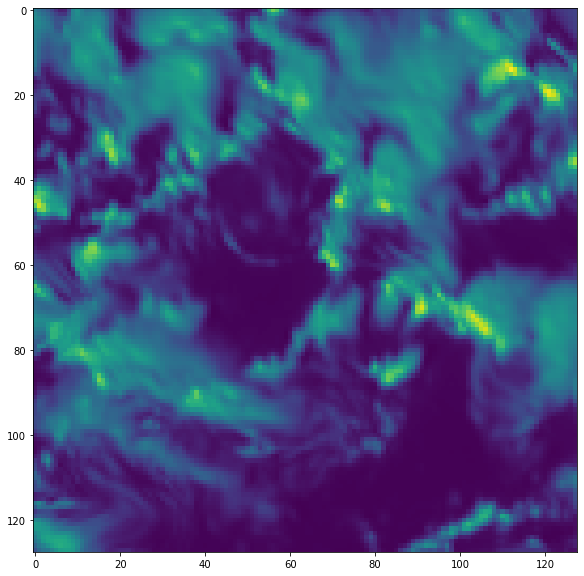

In [39]:
i = 11
plt.imshow(d[INPUT_IMAGES][i][0].cpu())

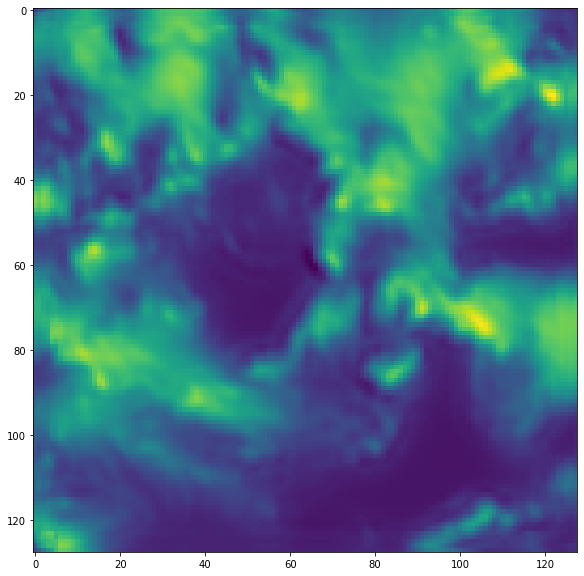

In [40]:
plt.imshow(output[i, 0].cpu().detach().numpy())

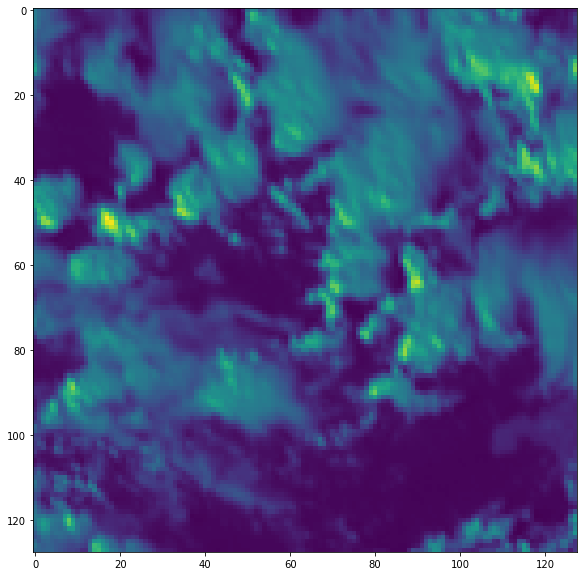

In [41]:
plt.imshow(d[TARGET_IMAGES][i][0].cpu())